**Week** 5. 

# Week 5: Alameda Country Housing Price and Income Analysis (Viswanathan)

#Installations and Importing Libraries

In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
pip install geopandas #need to install before using

In [104]:
#importing libraries that I plan to use

#Arrays, Tables, and Dataframe Libraries
from datascience import *
import pandas as pd 
import numpy as np

#Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas

#Tokenization and Stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#Webscraping
import requests
from bs4 import BeautifulSoup


#Loading CSV (downloaded through Zillow API) into a Pandas Dataframe

In [105]:
zillow_data = pd.read_csv("/content/drive/MyDrive/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv")
zillow_data

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,...,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,200075.0,198830.0,198897.0,198875.0,199330.0,199883.0,199785.0,200486.0,200791.0,202185.0,203256.0,204599.0,205854.0,208337.0,209743.0,210538.0,211254.0,212008.0,214267.0,214731.0,216143.0,215848.0,217565.0,219811.0,222770.0,225601.0,229202.0,233366.0,236664.0,240139.0,242354.0,...,1017039.0,1027584.0,1038953.0,1058026.0,1062802.0,1072237.0,1070957.0,1083433.0,1078314.0,1078464.0,1069361.0,1065229.0,1083891.0,1095244.0,1116158.0,1110777.0,1110752.0,1100678.0,1081990.0,1056843.0,1052388.0,1056984.0,1068839.0,1065266.0,1064037.0,1051885.0,1033799.0,1025042.0,1023762.0,1030265.0,1044070.0,1059557.0,1067331.0,1068534.0,1069807.0,1081347.0,1081855.0,1092196.0,1104487.0,1121360.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,266953.0,266255.0,265226.0,264005.0,262194.0,261265.0,259796.0,261551.0,263668.0,268043.0,271194.0,273875.0,275390.0,276139.0,277481.0,277514.0,278723.0,278493.0,279105.0,273341.0,266862.0,256874.0,250329.0,245524.0,243611.0,243305.0,243173.0,244126.0,244968.0,246046.0,247259.0,...,500490.0,503618.0,503321.0,501952.0,501775.0,502644.0,501921.0,501393.0,501173.0,502087.0,503423.0,503898.0,501679.0,498741.0,497160.0,497229.0,497914.0,497895.0,498210.0,497380.0,495573.0,493739.0,492233.0,491211.0,491579.0,492792.0,495301.0,496676.0,497142.0,497434.0,498824.0,500922.0,503725.0,506441.0,508991.0,511451.0,513654.0,515983.0,517482.0,519569.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,270721.0,270778.0,270928.0,271892.0,273296.0,274445.0,274827.0,274941.0,275373.0,276192.0,277288.0,278418.0,279930.0,282078.0,284714.0,286627.0,288259.0,290317.0,293412.0,296630.0,299798.0,302747.0,305990.0,309695.0,313155.0,315606.0,317359.0,318912.0,320546.0,322994.0,325994.0,...,1118937.0,1143405.0,1157115.0,1166380.0,1153814.0,1149301.0,1149279.0,1164975.0,1182952.0,1194928.0,1187956.0,1161743.0,1135281.0,1109912.0,1109211.0,1096399.0,1094837.0,1090185.0,1090223.0,1083327.0,1062489.0,1056177.0,1064622.0,1090206.0,1116017.0,1126414.0,1126998.0,1128540.0,1131833.0,1131653.0,1131516.0,1133589.0,1144334.0,1144987.0,1140435.0,1130923.0,1121519.0,1120821.0,1118048.0,1120428.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,202764.0,203015.0,202815.0,201613.0,200462.0,199788.0,200559.0,200243.0,199583.0,198783.0,199696.0,201400.0,203988.0,205247.0,206537.0,208768.0,211253.0,212984.0,212649.0,214817.0,217355.0,219585.0,218642.0,216914.0,214151.0,212522.0,210797.0,209847.0,208798.0,208384.0,208275.0,...,336842.0,337027.0,336740.0,337165.0,338230.0,339089.0,339159.0,339568.0,340104.0,340498.0,340884.0,340333.0,340630.0,340471.0,340445.0,339382.0,338793.0,338852.0,339754.0,340069.0,340740.0,340844.0,340833.0,340166.0,339808.0,339685.0,339983.0,340576.0,341578.0,342531.0,343268.0,344710.0,346294.0,348806.0,351884.0,356253.0,360496.0,365462.0,370763.0,376914.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,358937.0,357924.0,356564.0,354951.0,352590.0,351119.0,348860.0,350886.0,353574.0,359379.0,363727.0,367727.

Some Issues with the downloaded json: 

1.   Initially I planned to only look at housing data in Berkeley. However, from what I can see, zillow does not offer data for each listing, only estimates, medians, and generalized data by region. 

2.   Some columns are repetitive, or have no value (ex RegionType is always "Zip". StateName and State are the same.

3.   Since I plan to create a map-like visualization using geopandas, having a low amount of data is not effective. Because of this, and (1), I switched my question to involve the entirity of Alameda County



# Data Cleaning

First, I remove unnecesary columns

In [106]:
zillow_data = zillow_data.drop(['RegionType','StateName'], axis = 1)
zillow_data

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,...,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30
0,61639,0,10025,NY,New York,New York-Newark-Jersey City,New York County,200075.0,198830.0,198897.0,198875.0,199330.0,199883.0,199785.0,200486.0,200791.0,202185.0,203256.0,204599.0,205854.0,208337.0,209743.0,210538.0,211254.0,212008.0,214267.0,214731.0,216143.0,215848.0,217565.0,219811.0,222770.0,225601.0,229202.0,233366.0,236664.0,240139.0,242354.0,246643.0,250765.0,...,1017039.0,1027584.0,1038953.0,1058026.0,1062802.0,1072237.0,1070957.0,1083433.0,1078314.0,1078464.0,1069361.0,1065229.0,1083891.0,1095244.0,1116158.0,1110777.0,1110752.0,1100678.0,1081990.0,1056843.0,1052388.0,1056984.0,1068839.0,1065266.0,1064037.0,1051885.0,1033799.0,1025042.0,1023762.0,1030265.0,1044070.0,1059557.0,1067331.0,1068534.0,1069807.0,1081347.0,1081855.0,1092196.0,1104487.0,1121360.0
1,84654,1,60657,IL,Chicago,Chicago-Naperville-Elgin,Cook County,266953.0,266255.0,265226.0,264005.0,262194.0,261265.0,259796.0,261551.0,263668.0,268043.0,271194.0,273875.0,275390.0,276139.0,277481.0,277514.0,278723.0,278493.0,279105.0,273341.0,266862.0,256874.0,250329.0,245524.0,243611.0,243305.0,243173.0,244126.0,244968.0,246046.0,247259.0,251371.0,256804.0,...,500490.0,503618.0,503321.0,501952.0,501775.0,502644.0,501921.0,501393.0,501173.0,502087.0,503423.0,503898.0,501679.0,498741.0,497160.0,497229.0,497914.0,497895.0,498210.0,497380.0,495573.0,493739.0,492233.0,491211.0,491579.0,492792.0,495301.0,496676.0,497142.0,497434.0,498824.0,500922.0,503725.0,506441.0,508991.0,511451.0,513654.0,515983.0,517482.0,519569.0
2,61637,2,10023,NY,New York,New York-Newark-Jersey City,New York County,270721.0,270778.0,270928.0,271892.0,273296.0,274445.0,274827.0,274941.0,275373.0,276192.0,277288.0,278418.0,279930.0,282078.0,284714.0,286627.0,288259.0,290317.0,293412.0,296630.0,299798.0,302747.0,305990.0,309695.0,313155.0,315606.0,317359.0,318912.0,320546.0,322994.0,325994.0,329690.0,332342.0,...,1118937.0,1143405.0,1157115.0,1166380.0,1153814.0,1149301.0,1149279.0,1164975.0,1182952.0,1194928.0,1187956.0,1161743.0,1135281.0,1109912.0,1109211.0,1096399.0,1094837.0,1090185.0,1090223.0,1083327.0,1062489.0,1056177.0,1064622.0,1090206.0,1116017.0,1126414.0,1126998.0,1128540.0,1131833.0,1131653.0,1131516.0,1133589.0,1144334.0,1144987.0,1140435.0,1130923.0,1121519.0,1120821.0,1118048.0,1120428.0
3,91982,3,77494,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,202764.0,203015.0,202815.0,201613.0,200462.0,199788.0,200559.0,200243.0,199583.0,198783.0,199696.0,201400.0,203988.0,205247.0,206537.0,208768.0,211253.0,212984.0,212649.0,214817.0,217355.0,219585.0,218642.0,216914.0,214151.0,212522.0,210797.0,209847.0,208798.0,208384.0,208275.0,206983.0,206463.0,...,336842.0,337027.0,336740.0,337165.0,338230.0,339089.0,339159.0,339568.0,340104.0,340498.0,340884.0,340333.0,340630.0,340471.0,340445.0,339382.0,338793.0,338852.0,339754.0,340069.0,340740.0,340844.0,340833.0,340166.0,339808.0,339685.0,339983.0,340576.0,341578.0,342531.0,343268.0,344710.0,346294.0,348806.0,351884.0,356253.0,360496.0,365462.0,370763.0,376914.0
4,84616,4,60614,IL,Chicago,Chicago-Naperville-Elgin,Cook County,358937.0,357924.0,356564.0,354951.0,352590.0,351119.0,348860.0,35088

I now make three datasets:

1. Only California
2. Only Berkeley
3. Only Alameda County

I primarily use the Alameda County Dataset. The Berkeley Dataset goes unused, but was created, and is left in, for further analysis. Berkeley is unique because of its relatively large homesless population, a large public university, and a widely varied wealth distribution within the city by location.

In [107]:
zillow_data_ca = zillow_data.where(zillow_data["State"] == "CA").dropna()
zillow_data_ca

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,...,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30
13,97564.0,13.0,94109.0,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,322659.0,321188.0,320785.0,319746.0,319574.0,319324.0,319489.0,320136.0,321355.0,322471.0,323901.0,325353.0,328122.0,331601.0,334930.0,336913.0,338955.0,341473.0,344790.0,347477.0,350164.0,353428.0,357315.0,361532.0,365083.0,368796.0,372238.0,377898.0,382904.0,388744.0,393383.0,399210.0,404969.0,...,1176384.0,1179219.0,1191921.0,1205948.0,1211841.0,1220257.0,1224632.0,1229046.0,1226684.0,1225169.0,1219044.0,1210957.0,1212832.0,1213087.0,1209796.0,1201389.0,1203236.0,1206723.0,1207311.0,1203335.0,1201971.0,1212663.0,1222894.0,1238320.0,1241526.0,1246576.0,1241955.0,1240585.0,1232525.0,1224867.0,1218991.0,1215151.0,1211960.0,1199466.0,1188854.0,1174705.0,1164562.0,1151840.0,1144533.0,1135677.0
21,96107.0,22.0,90250.0,CA,Hawthorne,Los Angeles-Long Beach-Anaheim,Los Angeles County,176095.0,176436.0,176811.0,177487.0,178107.0,178546.0,178871.0,178934.0,178763.0,178505.0,178386.0,178352.0,177669.0,176715.0,175734.0,175374.0,175026.0,174994.0,175352.0,176216.0,177182.0,178025.0,178495.0,179187.0,180577.0,182694.0,184591.0,185914.0,187268.0,188161.0,188478.0,188665.0,189536.0,...,630495.0,635737.0,642347.0,647332.0,651450.0,654953.0,659109.0,661525.0,663711.0,665954.0,668519.0,669253.0,669168.0,666689.0,664650.0,664615.0,668946.0,674065.0,675383.0,675155.0,675030.0,676709.0,678652.0,683865.0,689748.0,696789.0,702966.0,707870.0,709524.0,710409.0,715490.0,723183.0,731585.0,739307.0,746788.0,752952.0,759414.0,766871.0,775357.0,785096.0
39,97771.0,40.0,94565.0,CA,Pittsburg,San Francisco-Oakland-Hayward,Contra Costa County,216114.0,214086.0,213214.0,211144.0,210033.0,208643.0,207589.0,206723.0,206422.0,205965.0,206075.0,206643.0,208763.0,211196.0,212455.0,213151.0,213307.0,213916.0,213811.0,214179.0,215216.0,216254.0,216747.0,217180.0,213653.0,210549.0,207811.0,209166.0,210983.0,213586.0,217125.0,219937.0,220711.0,...,575078.0,580942.0,584307.0,584064.0,586801.0,590681.0,595398.0,594382.0,595566.0,596224.0,596559.0,593678.0,593030.0,591419.0,589679.0,587572.0,589412.0,590396.0,590294.0,587567.0,584462.0,583618.0,585114.0,589944.0,590635.0,590928.0,592452.0,595476.0,595075.0,594876.0,596776.0,603869.0,610486.0,617031.0,622186.0,627238.0,634925.0,645082.0,656102.0,668272.0
43,96027.0,44.0,90046.0,CA,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles County,311227.0,311895.0,311440.0,310882.0,310043.0,309505.0,309981.0,310004.0,310477.0,310775.0,311519.0,312468.0,312826.0,312700.0,314416.0,317321.0,320772.0,323788.0,326342.0,330118.0,333151.0,336889.0,340804.0,345498.0,351113.0,356480.0,360353.0,363590.0,367710.0,372487.0,375900.0,379708.0,385242.0,...,1417680.0,1432305.0,1447897.0,1456546.0,1456304.0,1456526.0,1452992.0,1450713.0,1446902.0,1450913.0,1455832.0,1456440.0,1455317.0,1448316.0,1443173.0,1443496.0,1452984.0,1463346.0,1455678.0,1446014.0,1439102.0,1447165.0,1451719.0,1459453.0,1463362.0,1473191.0,1481063.0,1488087.0,1489349.0,1490263.0,1508617.0,1528594.0,1547222.0,1551625.0,1557785.0,1564499.0,1575469.0,1585634.0,1597359.0,1609412.0
87,97711.0,88.0,94501.0,CA,Alameda,San Francisco-Oakland

In [108]:
berk_zillow = zillow_data_ca.where(zillow_data_ca["City"] == "Berkeley").dropna()
berk_zillow = berk_zillow.sort_values("RegionName")
berk_zillow

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,...,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30
6150,97836.0,6205.0,94702.0,CA,Berkeley,San Francisco-Oakland-Hayward,Alameda County,182269.0,181729.0,181264.0,180354.0,179876.0,179433.0,178857.0,178226.0,177792.0,178423.0,179526.0,181327.0,183008.0,184384.0,185920.0,187893.0,190327.0,191860.0,193848.0,196306.0,199588.0,201461.0,202490.0,203091.0,204046.0,205990.0,207925.0,209906.0,211049.0,214470.0,218767.0,222951.0,226087.0,...,1025422.0,1034023.0,1039654.0,1049521.0,1060625.0,1063723.0,1053740.0,1042038.0,1029832.0,1027501.0,1026832.0,1023948.0,1017318.0,1011455.0,1008904.0,1012062.0,1018718.0,1029567.0,1034301.0,1037708.0,1045113.0,1050124.0,1053387.0,1057862.0,1069883.0,1076953.0,1078520.0,1074521.0,1073015.0,1073873.0,1082234.0,1094504.0,1105382.0,1117616.0,1131252.0,1147686.0,1161549.0,1182536.0,1209908.0,1241513.0
5483,97837.0,5531.0,94703.0,CA,Berkeley,San Francisco-Oakland-Hayward,Alameda County,223417.0,222394.0,222100.0,221245.0,220617.0,219696.0,218643.0,218624.0,219262.0,220174.0,220640.0,220926.0,221647.0,222781.0,223960.0,225802.0,228588.0,231508.0,235123.0,237173.0,238936.0,240392.0,243132.0,246426.0,248801.0,251510.0,254332.0,257192.0,258655.0,260897.0,263589.0,267158.0,270590.0,...,1174565.0,1189540.0,1199140.0,1211624.0,1229754.0,1242043.0,1238389.0,1232168.0,1225430.0,1232082.0,1232179.0,1223224.0,1208657.0,1201563.0,1195425.0,1195629.0,1198121.0,1210064.0,1220310.0,1227623.0,1240581.0,1246415.0,1249464.0,1257070.0,1272094.0,1279294.0,1282255.0,1276726.0,1274508.0,1267040.0,1268206.0,1274223.0,1276778.0,1281147.0,1290302.0,1301813.0,1310740.0,1325346.0,1345890.0,1371920.0
5226,97838.0,5271.0,94704.0,CA,Berkeley,San Francisco-Oakland-Hayward,Alameda County,235747.0,235906.0,235839.0,235880.0,235913.0,236048.0,235899.0,236670.0,237946.0,239619.0,240421.0,241004.0,241677.0,242624.0,243974.0,246154.0,249207.0,251918.0,255229.0,257131.0,258932.0,260170.0,263152.0,267107.0,270894.0,273942.0,277263.0,280290.0,282131.0,284350.0,287597.0,290246.0,292609.0,...,1204843.0,1217580.0,1226657.0,1236804.0,1251473.0,1255712.0,1247014.0,1238544.0,1230606.0,1228340.0,1219420.0,1205141.0,1193977.0,1193281.0,1192716.0,1196078.0,1201724.0,1212633.0,1222492.0,1227973.0,1235131.0,1240953.0,1242123.0,1252117.0,1262338.0,1264194.0,1263874.0,1258263.0,1255661.0,1251207.0,1253951.0,1261562.0,1268634.0,1277157.0,1293180.0,1306547.0,1319614.0,1337552.0,1360325.0,1388235.0
7473,97839.0,7545.0,94705.0,CA,Berkeley,San Francisco-Oakland-Hayward,Alameda County,371718.0,370084.0,369517.0,368629.0,368165.0,367931.0,367968.0,369219.0,371459.0,373852.0,375836.0,377098.0,378810.0,382217.0,385992.0,389464.0,393011.0,396462.0,400696.0,404021.0,406218.0,408232.0,412090.0,417577.0,422776.0,426749.0,430989.0,435798.0,440587.0,445045.0,448911.0,451690.0,455965.0,...,1737625.0,1754968.0,1766461.0,1781743.0,1807183.0,1819660.0,1806222.0,1788347.0,1773766.0,1772824.0,1768137.0,1750521.0,1732667.0,1728492.0,1725870.0,1730299.0,1737979.0,1754761.0,1777932.0,1789399.0,1798469.0,1796825.0,1796125.0,1814201.0,1840730.0,1855503.0,1863830.0,1858435.0,1853001.0,1844216.0,1847180.0,1863964.0,1881907.0,1905823.0,1932309.0,1952673.0,1968465.0,1992536.0,2026636.0,2

In [109]:
ala_zillow = zillow_data_ca.where(zillow_data_ca["CountyName"] == "Alameda County").dropna()
ala_zillow = ala_zillow.drop_duplicates(subset = "City")
ala_zillow

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,...,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30
87,97711.0,88.0,94501.0,CA,Alameda,San Francisco-Oakland-Hayward,Alameda County,236313.0,235064.0,234702.0,234010.0,234003.0,233406.0,232595.0,232051.0,232044.0,232635.0,233217.0,234108.0,234709.0,236102.0,237215.0,238671.0,240175.0,242513.0,245183.0,247414.0,249492.0,251208.0,253442.0,256151.0,259028.0,262131.0,265119.0,267992.0,269917.0,272076.0,275220.0,278768.0,282425.0,...,1035262.0,1044099.0,1046714.0,1052418.0,1060725.0,1065824.0,1059014.0,1053738.0,1043256.0,1044776.0,1043678.0,1037477.0,1027679.0,1023010.0,1026255.0,1032785.0,1042839.0,1051843.0,1062356.0,1063014.0,1065695.0,1061677.0,1060439.0,1068630.0,1086458.0,1096770.0,1101045.0,1095536.0,1091201.0,1086732.0,1089902.0,1101446.0,1114507.0,1129801.0,1144950.0,1156504.0,1164176.0,1178355.0,1197210.0,1224726.0
229,97743.0,231.0,94536.0,CA,Fremont,San Francisco-Oakland-Hayward,Alameda County,210316.0,209862.0,209848.0,210000.0,210620.0,210976.0,211083.0,211366.0,212101.0,213334.0,214485.0,215705.0,216508.0,217885.0,219390.0,221388.0,223422.0,225585.0,228273.0,230913.0,233545.0,235639.0,238121.0,241039.0,244192.0,247097.0,249779.0,251995.0,253784.0,256227.0,259432.0,262386.0,265003.0,...,1014086.0,1026217.0,1036409.0,1054192.0,1078826.0,1099314.0,1117919.0,1129339.0,1135742.0,1133547.0,1129898.0,1119756.0,1110061.0,1104847.0,1100328.0,1094959.0,1090676.0,1087800.0,1080804.0,1068617.0,1059092.0,1052965.0,1047571.0,1050597.0,1061692.0,1069357.0,1074072.0,1070041.0,1066099.0,1062912.0,1067393.0,1079988.0,1093739.0,1110501.0,1128801.0,1145351.0,1157914.0,1175027.0,1197903.0,1230785.0
312,97751.0,314.0,94544.0,CA,Hayward,San Francisco-Oakland-Hayward,Alameda County,169985.0,169298.0,169209.0,169154.0,169557.0,169678.0,169538.0,169556.0,169782.0,170200.0,170541.0,170934.0,170940.0,171384.0,171697.0,172193.0,172635.0,173333.0,174587.0,175575.0,176503.0,177137.0,178097.0,179409.0,181035.0,182869.0,184714.0,186373.0,187430.0,188695.0,190205.0,191844.0,193646.0,...,638594.0,645939.0,651301.0,659268.0,669368.0,676168.0,680713.0,683018.0,684629.0,682755.0,680729.0,674080.0,669156.0,666342.0,665143.0,665134.0,666874.0,669302.0,669327.0,665979.0,663200.0,661321.0,659921.0,664393.0,673466.0,679743.0,684207.0,682661.0,681398.0,680178.0,683890.0,692208.0,700923.0,711632.0,722521.0,731754.0,737881.0,747185.0,759252.0,777062.0
337,97774.0,339.0,94568.0,CA,Dublin,San Francisco-Oakland-Hayward,Alameda County,262837.0,262148.0,262032.0,261983.0,262360.0,262479.0,262256.0,262254.0,262465.0,263479.0,264411.0,265459.0,265683.0,266458.0,267329.0,268628.0,270138.0,271663.0,273729.0,275638.0,277698.0,278645.0,279848.0,281544.0,284244.0,286951.0,289420.0,291464.0,292881.0,295046.0,298269.0,301308.0,304577.0,...,953028.0,960834.0,965066.0,973393.0,985055.0,992559.0,998487.0,1002319.0,1002942.0,998901.0,994092.0,985466.0,976465.0,970713.0,967382.0,966088.0,967311.0,969972.0,969654.0,963915.0,958531.0,955163.0,952745.0,958287.0,970822.0,979470.0,982868.0,976729.0,970613.0,965769.0,968040.0,976908.0,988143.0,1001921.0,1016739.0,1028909.0,1038293.0,1052818.0,1074247.0,1105405.0
500,97792.0,503.0,94587.0,CA,Union City,San Francisco-Oakland-Hayward,Alameda

# Average Change over Time

Looking at general trend, and if any particular times have interesting events.

Some further analysis can be done through adding other datasets (ex: how natural disasters in areas can impact prices.

Text(0.5, 1.0, 'House Price By City Over Time (Alameda County)')

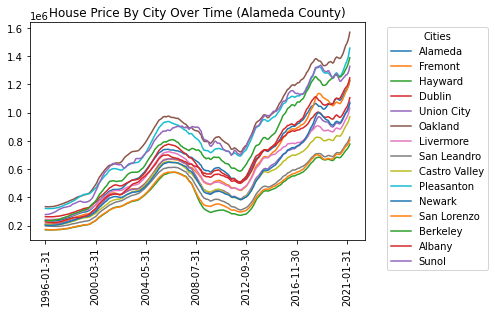

In [110]:
ala_zillow.columns
ala_zillow_HO = ala_zillow.drop(labels = ['RegionID', 'SizeRank','RegionName', 'State', 'Metro',
       'CountyName'],  axis = 1).set_index("City")

%matplotlib inline
ala_zillow_HO.T.plot()
plt.xticks(rotation = 90)
plt.legend(title='Cities', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("House Price By City Over Time (Alameda County)")

#Replace Numbers in legend with City Name

We notice that there the general trend for housing prices is the same for all the listed cities. However, there is a dip in housing prices that starts around a peak in 2006, and lasts until 2012. Initially, I believed this was due to the 2008 Recession. However, the reccession lasted from 2008-2009, so the timing does not line up. 

Further analysis needs to be done.

ex: Can housing prices predict economic failure and success within the nation?

# Preparing Data for CARTO DB


In [111]:
ala_carto = ala_zillow
ala_carto

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,...,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30
87,97711.0,88.0,94501.0,CA,Alameda,San Francisco-Oakland-Hayward,Alameda County,236313.0,235064.0,234702.0,234010.0,234003.0,233406.0,232595.0,232051.0,232044.0,232635.0,233217.0,234108.0,234709.0,236102.0,237215.0,238671.0,240175.0,242513.0,245183.0,247414.0,249492.0,251208.0,253442.0,256151.0,259028.0,262131.0,265119.0,267992.0,269917.0,272076.0,275220.0,278768.0,282425.0,...,1035262.0,1044099.0,1046714.0,1052418.0,1060725.0,1065824.0,1059014.0,1053738.0,1043256.0,1044776.0,1043678.0,1037477.0,1027679.0,1023010.0,1026255.0,1032785.0,1042839.0,1051843.0,1062356.0,1063014.0,1065695.0,1061677.0,1060439.0,1068630.0,1086458.0,1096770.0,1101045.0,1095536.0,1091201.0,1086732.0,1089902.0,1101446.0,1114507.0,1129801.0,1144950.0,1156504.0,1164176.0,1178355.0,1197210.0,1224726.0
229,97743.0,231.0,94536.0,CA,Fremont,San Francisco-Oakland-Hayward,Alameda County,210316.0,209862.0,209848.0,210000.0,210620.0,210976.0,211083.0,211366.0,212101.0,213334.0,214485.0,215705.0,216508.0,217885.0,219390.0,221388.0,223422.0,225585.0,228273.0,230913.0,233545.0,235639.0,238121.0,241039.0,244192.0,247097.0,249779.0,251995.0,253784.0,256227.0,259432.0,262386.0,265003.0,...,1014086.0,1026217.0,1036409.0,1054192.0,1078826.0,1099314.0,1117919.0,1129339.0,1135742.0,1133547.0,1129898.0,1119756.0,1110061.0,1104847.0,1100328.0,1094959.0,1090676.0,1087800.0,1080804.0,1068617.0,1059092.0,1052965.0,1047571.0,1050597.0,1061692.0,1069357.0,1074072.0,1070041.0,1066099.0,1062912.0,1067393.0,1079988.0,1093739.0,1110501.0,1128801.0,1145351.0,1157914.0,1175027.0,1197903.0,1230785.0
312,97751.0,314.0,94544.0,CA,Hayward,San Francisco-Oakland-Hayward,Alameda County,169985.0,169298.0,169209.0,169154.0,169557.0,169678.0,169538.0,169556.0,169782.0,170200.0,170541.0,170934.0,170940.0,171384.0,171697.0,172193.0,172635.0,173333.0,174587.0,175575.0,176503.0,177137.0,178097.0,179409.0,181035.0,182869.0,184714.0,186373.0,187430.0,188695.0,190205.0,191844.0,193646.0,...,638594.0,645939.0,651301.0,659268.0,669368.0,676168.0,680713.0,683018.0,684629.0,682755.0,680729.0,674080.0,669156.0,666342.0,665143.0,665134.0,666874.0,669302.0,669327.0,665979.0,663200.0,661321.0,659921.0,664393.0,673466.0,679743.0,684207.0,682661.0,681398.0,680178.0,683890.0,692208.0,700923.0,711632.0,722521.0,731754.0,737881.0,747185.0,759252.0,777062.0
337,97774.0,339.0,94568.0,CA,Dublin,San Francisco-Oakland-Hayward,Alameda County,262837.0,262148.0,262032.0,261983.0,262360.0,262479.0,262256.0,262254.0,262465.0,263479.0,264411.0,265459.0,265683.0,266458.0,267329.0,268628.0,270138.0,271663.0,273729.0,275638.0,277698.0,278645.0,279848.0,281544.0,284244.0,286951.0,289420.0,291464.0,292881.0,295046.0,298269.0,301308.0,304577.0,...,953028.0,960834.0,965066.0,973393.0,985055.0,992559.0,998487.0,1002319.0,1002942.0,998901.0,994092.0,985466.0,976465.0,970713.0,967382.0,966088.0,967311.0,969972.0,969654.0,963915.0,958531.0,955163.0,952745.0,958287.0,970822.0,979470.0,982868.0,976729.0,970613.0,965769.0,968040.0,976908.0,988143.0,1001921.0,1016739.0,1028909.0,1038293.0,1052818.0,1074247.0,1105405.0
500,97792.0,503.0,94587.0,CA,Union City,San Francisco-Oakland-Hayward,Alameda

I decide to add in two sets of income data. This is used for a future section, and can be done later. The reason it is done earlier is to aid in cartoDB visuals

In [112]:
#http://www.healthyalamedacounty.org/indicators/index/view?indicatorId=315&localeId=132161&periodId=4523  

household_incs_2010 = np.array([74221, 96287, 61268, 107754, 83629, 49721, 93988, 62609, 80113, 115188, 81352, 70934, 58617, 71994, 84167])
household_incs_2019 = np.array([104756, 133354, 86744, 150299, 114681, 73692, 127452, 78003, 108488, 156400, 116856, 97286, 85530, 95400, 129231])

In [113]:
ala_carto["Household Income (2006-2010)"] = household_incs_2010
ala_carto["Household Income (2015-2019)"] = household_incs_2019
ala_carto

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,Household Income (2006-2010),Household Income (2015-2019)
87,97711.0,88.0,94501.0,CA,Alameda,San Francisco-Oakland-Hayward,Alameda County,236313.0,235064.0,234702.0,234010.0,234003.0,233406.0,232595.0,232051.0,232044.0,232635.0,233217.0,234108.0,234709.0,236102.0,237215.0,238671.0,240175.0,242513.0,245183.0,247414.0,249492.0,251208.0,253442.0,256151.0,259028.0,262131.0,265119.0,267992.0,269917.0,272076.0,275220.0,278768.0,282425.0,...,1046714.0,1052418.0,1060725.0,1065824.0,1059014.0,1053738.0,1043256.0,1044776.0,1043678.0,1037477.0,1027679.0,1023010.0,1026255.0,1032785.0,1042839.0,1051843.0,1062356.0,1063014.0,1065695.0,1061677.0,1060439.0,1068630.0,1086458.0,1096770.0,1101045.0,1095536.0,1091201.0,1086732.0,1089902.0,1101446.0,1114507.0,1129801.0,1144950.0,1156504.0,1164176.0,1178355.0,1197210.0,1224726.0,74221,104756
229,97743.0,231.0,94536.0,CA,Fremont,San Francisco-Oakland-Hayward,Alameda County,210316.0,209862.0,209848.0,210000.0,210620.0,210976.0,211083.0,211366.0,212101.0,213334.0,214485.0,215705.0,216508.0,217885.0,219390.0,221388.0,223422.0,225585.0,228273.0,230913.0,233545.0,235639.0,238121.0,241039.0,244192.0,247097.0,249779.0,251995.0,253784.0,256227.0,259432.0,262386.0,265003.0,...,1036409.0,1054192.0,1078826.0,1099314.0,1117919.0,1129339.0,1135742.0,1133547.0,1129898.0,1119756.0,1110061.0,1104847.0,1100328.0,1094959.0,1090676.0,1087800.0,1080804.0,1068617.0,1059092.0,1052965.0,1047571.0,1050597.0,1061692.0,1069357.0,1074072.0,1070041.0,1066099.0,1062912.0,1067393.0,1079988.0,1093739.0,1110501.0,1128801.0,1145351.0,1157914.0,1175027.0,1197903.0,1230785.0,96287,133354
312,97751.0,314.0,94544.0,CA,Hayward,San Francisco-Oakland-Hayward,Alameda County,169985.0,169298.0,169209.0,169154.0,169557.0,169678.0,169538.0,169556.0,169782.0,170200.0,170541.0,170934.0,170940.0,171384.0,171697.0,172193.0,172635.0,173333.0,174587.0,175575.0,176503.0,177137.0,178097.0,179409.0,181035.0,182869.0,184714.0,186373.0,187430.0,188695.0,190205.0,191844.0,193646.0,...,651301.0,659268.0,669368.0,676168.0,680713.0,683018.0,684629.0,682755.0,680729.0,674080.0,669156.0,666342.0,665143.0,665134.0,666874.0,669302.0,669327.0,665979.0,663200.0,661321.0,659921.0,664393.0,673466.0,679743.0,684207.0,682661.0,681398.0,680178.0,683890.0,692208.0,700923.0,711632.0,722521.0,731754.0,737881.0,747185.0,759252.0,777062.0,61268,86744
337,97774.0,339.0,94568.0,CA,Dublin,San Francisco-Oakland-Hayward,Alameda County,262837.0,262148.0,262032.0,261983.0,262360.0,262479.0,262256.0,262254.0,262465.0,263479.0,264411.0,265459.0,265683.0,266458.0,267329.0,268628.0,270138.0,271663.0,273729.0,275638.0,277698.0,278645.0,279848.0,281544.0,284244.0,286951.0,289420.0,291464.0,292881.0,295046.0,298269.0,301308.0,304577.0,...,965066.0,973393.0,985055.0,992559.0,998487.0,1002319.0,1002942.0,998901.0,994092.0,985466.0,976465.0,970713.0,967382.0,966088.0,967311.0,969972.0,969654.0,963915.0,958531.0,955163.0,952745.0,958287.0,970822.0,979470.0,982868.0,976729.0,970613.0,965769.0,968040.0,976908.0,988143.0,1001921.0,1016739.0,1028909.0,1038293.0,1052818.0,1074247.0,1105405.0,107754,150299
500,97792.0,503.0,94587.0,CA,Union City,San Francisco-Oakland-Hay

**Adding in latitude and longitude using GeoPandas**

In [114]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_user_agent")

lats = np.array([])
longs = np.array([])
city = ala_carto["City"]
country ="USA"
for i in city:
  loc = geolocator.geocode(i+','+ country)
  lats = np.append(lats,loc.latitude)
  longs = np.append (longs,loc.longitude)



In [115]:
lats,longs

(array([37.6090291 , 37.5482697 , 37.6688205 , 37.7021521 , 37.5963232 ,
        37.8044557 , 37.6820583 , 37.7249296 , 37.71573685, 37.6624312 ,
        40.735657  , 18.1524948 , 37.8753497 , 42.6511674 , 37.58334455]),
 array([-121.899142  , -121.988571  , -122.080796  , -121.9357918 ,
        -122.0816297 , -122.2713563 , -121.7680531 , -122.1560768 ,
        -122.09063177, -121.8746789 ,  -74.1723667 ,  -65.97563436,
        -122.23963365,  -73.754968  , -121.89333723]))

In [116]:
'''
Albany got mapped to the new york albany, 
Newark got mapped to New Jersey, 
San Lorenzo got mapped somewhere near the Dominican Republic
'''

#Correcting Albany

lats[len(lats)-2],longs[len(lats)-2] = 37.8867,-122.2978

#Correcting Newark
lats[len(lats)-5],longs[len(lats)-5] = 37.5300, -122.0384

#Correcting San Lorenzo
lats[len(lats)-4],longs[len(lats)-4] = 37.6794, -122.1267
 
lats,longs

(array([37.6090291 , 37.5482697 , 37.6688205 , 37.7021521 , 37.5963232 ,
        37.8044557 , 37.6820583 , 37.7249296 , 37.71573685, 37.6624312 ,
        37.53      , 37.6794    , 37.8753497 , 37.8867    , 37.58334455]),
 array([-121.899142  , -121.988571  , -122.080796  , -121.9357918 ,
        -122.0816297 , -122.2713563 , -121.7680531 , -122.1560768 ,
        -122.09063177, -121.8746789 , -122.0384    , -122.1267    ,
        -122.23963365, -122.2978    , -121.89333723]))

In [117]:
ala_carto["Latitude"] = lats
ala_carto["Longitude"] = longs
ala_carto["Country"] = np.full((15,1),"United States")
ala_carto

,RegionID,SizeRank,RegionName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,...,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,Household Income (2006-2010),Household Income (2015-2019),Latitude,Longitude,Country
87,97711.0,88.0,94501.0,CA,Alameda,San Francisco-Oakland-Hayward,Alameda County,236313.0,235064.0,234702.0,234010.0,234003.0,233406.0,232595.0,232051.0,232044.0,232635.0,233217.0,234108.0,234709.0,236102.0,237215.0,238671.0,240175.0,242513.0,245183.0,247414.0,249492.0,251208.0,253442.0,256151.0,259028.0,262131.0,265119.0,267992.0,269917.0,272076.0,275220.0,278768.0,282425.0,...,1065824.0,1059014.0,1053738.0,1043256.0,1044776.0,1043678.0,1037477.0,1027679.0,1023010.0,1026255.0,1032785.0,1042839.0,1051843.0,1062356.0,1063014.0,1065695.0,1061677.0,1060439.0,1068630.0,1086458.0,1096770.0,1101045.0,1095536.0,1091201.0,1086732.0,1089902.0,1101446.0,1114507.0,1129801.0,1144950.0,1156504.0,1164176.0,1178355.0,1197210.0,1224726.0,74221,104756,37.609029,-121.899142,United States
229,97743.0,231.0,94536.0,CA,Fremont,San Francisco-Oakland-Hayward,Alameda County,210316.0,209862.0,209848.0,210000.0,210620.0,210976.0,211083.0,211366.0,212101.0,213334.0,214485.0,215705.0,216508.0,217885.0,219390.0,221388.0,223422.0,225585.0,228273.0,230913.0,233545.0,235639.0,238121.0,241039.0,244192.0,247097.0,249779.0,251995.0,253784.0,256227.0,259432.0,262386.0,265003.0,...,1099314.0,1117919.0,1129339.0,1135742.0,1133547.0,1129898.0,1119756.0,1110061.0,1104847.0,1100328.0,1094959.0,1090676.0,1087800.0,1080804.0,1068617.0,1059092.0,1052965.0,1047571.0,1050597.0,1061692.0,1069357.0,1074072.0,1070041.0,1066099.0,1062912.0,1067393.0,1079988.0,1093739.0,1110501.0,1128801.0,1145351.0,1157914.0,1175027.0,1197903.0,1230785.0,96287,133354,37.548270,-121.988571,United States
312,97751.0,314.0,94544.0,CA,Hayward,San Francisco-Oakland-Hayward,Alameda County,169985.0,169298.0,169209.0,169154.0,169557.0,169678.0,169538.0,169556.0,169782.0,170200.0,170541.0,170934.0,170940.0,171384.0,171697.0,172193.0,172635.0,173333.0,174587.0,175575.0,176503.0,177137.0,178097.0,179409.0,181035.0,182869.0,184714.0,186373.0,187430.0,188695.0,190205.0,191844.0,193646.0,...,676168.0,680713.0,683018.0,684629.0,682755.0,680729.0,674080.0,669156.0,666342.0,665143.0,665134.0,666874.0,669302.0,669327.0,665979.0,663200.0,661321.0,659921.0,664393.0,673466.0,679743.0,684207.0,682661.0,681398.0,680178.0,683890.0,692208.0,700923.0,711632.0,722521.0,731754.0,737881.0,747185.0,759252.0,777062.0,61268,86744,37.668821,-122.080796,United States
337,97774.0,339.0,94568.0,CA,Dublin,San Francisco-Oakland-Hayward,Alameda County,262837.0,262148.0,262032.0,261983.0,262360.0,262479.0,262256.0,262254.0,262465.0,263479.0,264411.0,265459.0,265683.0,266458.0,267329.0,268628.0,270138.0,271663.0,273729.0,275638.0,277698.0,278645.0,279848.0,281544.0,284244.0,286951.0,289420.0,291464.0,292881.0,295046.0,298269.0,301308.0,304577.0,...,992559.0,998487.0,1002319.0,1002942.0,998901.0,994092.0,985466.0,976465.0,970713.0,967382.0,966088.0,967311.0,969972.0,969654.0,963915.0,958531.0,955163.0,952745.0,958287.0,970822.0,979470.0,982868.0,976729.0,970613.0,965769.0,968040.0,976908.0,988143.0,1001921.0,1016739.0,1028909.0,1038293.0,1052818.0,1074247.0,1105405.0,107754,150299,37.702152,-121.935792,United States
500,97792.0,503.0,94587.0,CA,Union City,S

In [118]:
#We export the dataframe as a csv so we can use CartoDB and create visualizations. This can be done in GeoPandas, but is much easier in CartoDB
ala_carto_csv = ala_carto.to_csv("/content/drive/MyDrive/ala_carto_geo_updated4.csv")

Below is one of the Carto DB Visualizations. The Visualization shows two features in our dataset: the size rank, and the median household income, which are both explored in the following section. The size of the bubble corresponds to Zillow's size rank, and the color, as seen through the slider, shows the median household income for each area (based on 2019)

You can use the link to interact with this public visualization.


Side note: Double clicking on the below cell may cause you to lag.

1. [Carto DB Interactive](https://latias.carto.com/builder/7b743620-9633-4841-994d-b6c79dcb7a87/embed)

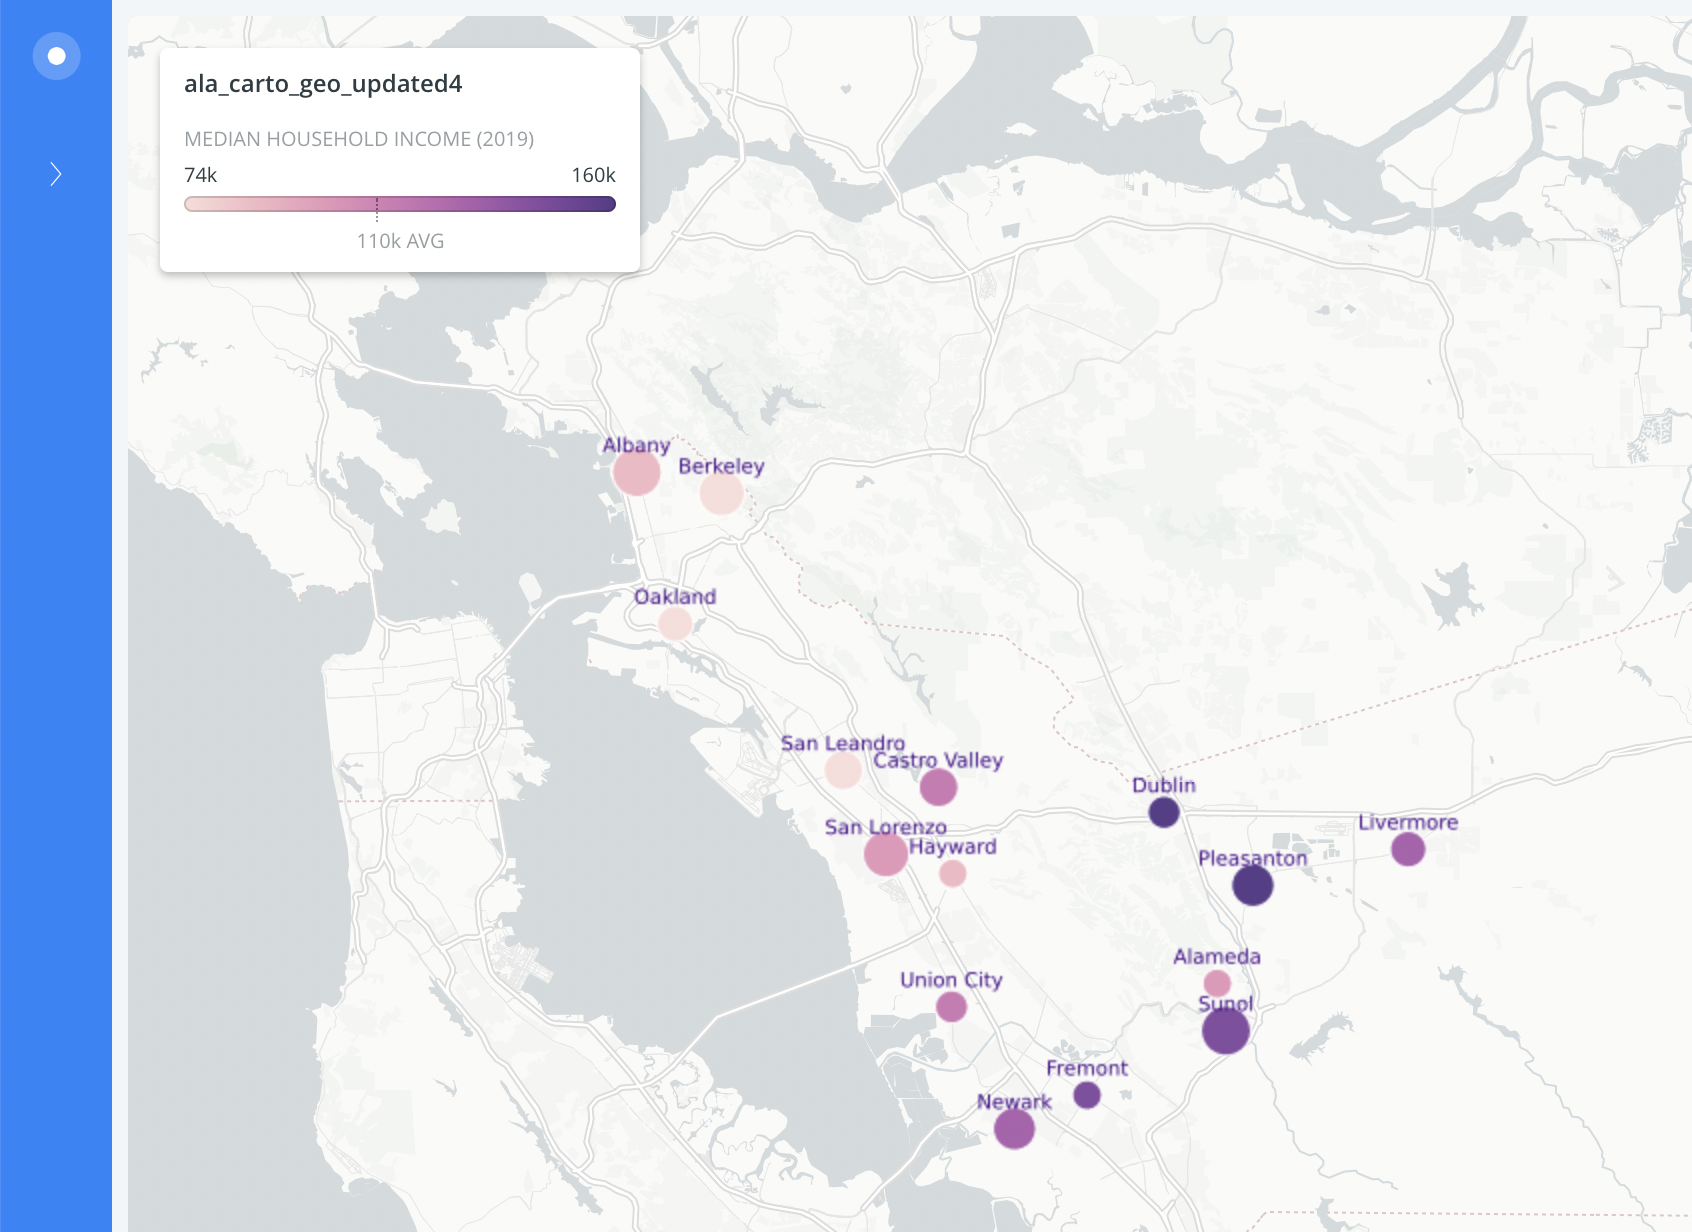

# Determining the Correlation between Median Household Income and Housing Price within Alameda County (and then checking Size Rank vs Housing Price

We want to determine wether or not there is a correlation between median household income and housing price. We look at 2 time periods: 2006-2010 and 2015-2020. 

Limitation: The income we use is from 2006-2010 and 2015-2020, as it is split into 4 year periods. However, our housing price data is split by month. I decided to use the end year for the income and housing data, creating an even 9 year gap. I do not believe that this should greatly impact the correlation, but may cause inaccuracies if this data is later used for prediction.

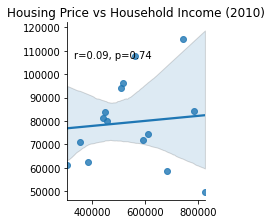

In [119]:
import scipy as sp

g = sns.lmplot(x = "2010-04-30", y = "Household Income (2006-2010)", data = ala_carto, height=3, aspect=1)
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(ala_carto["2010-04-30"], ala_carto["Household Income (2006-2010)"])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.title("Housing Price vs Household Income (2010)")
plt.show()

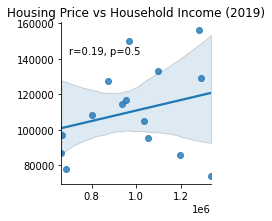

In [120]:
g2 = sns.lmplot(x = "2019-04-30", y = "Household Income (2015-2019)", data = ala_carto, height=3, aspect=1)
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(ala_carto["2010-04-30"], ala_carto["Household Income (2015-2019)"])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g2.map_dataframe(annotate)
plt.title("Housing Price vs Household Income (2019)")
plt.show()

**Interestingly, we notice that there is a very slight, essentially negligible, positive linear correlation between Housing Price and Household income, regardless of the time period.**

We have size rankings from Zillow. Let's see if these size rankings correlate more with Housing Price!

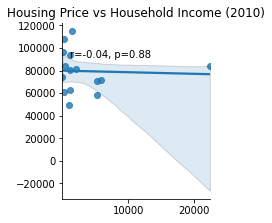

In [121]:
s = sns.lmplot(x = "SizeRank", y = "Household Income (2006-2010)", data = ala_carto, height=3, aspect=1)
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(ala_carto["SizeRank"], ala_carto["Household Income (2006-2010)"])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
s.map_dataframe(annotate)
plt.title("Housing Price vs Household Income (2010)")
plt.show()

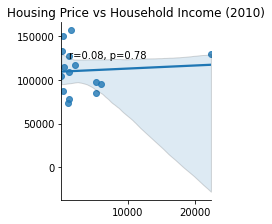

In [122]:
s2 = sns.lmplot(x = "SizeRank", y = "Household Income (2015-2019)", data = ala_carto, height=3, aspect=1)
def annotate(data, **kws):
    r, p = sp.stats.pearsonr(ala_carto["SizeRank"], ala_carto["Household Income (2015-2019)"])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
s2.map_dataframe(annotate)
plt.title("Housing Price vs Household Income (2010)")
plt.show()

**The Size Rank does not Correlate with House Price**

# Ratios between Median Income in 2020, and in 2000, for cities in Alameda County



In [123]:
x, y = np.array(ala_carto["2010-04-30"] /  ala_carto["Household Income (2006-2010)"]), np.array(ala_carto["2019-04-30"] /  ala_carto["Household Income (2015-2019)"])
x_avg, y_avg = np.mean(x), np.mean(y)
x_avg, y_avg 

(7.257388670567822, 9.310124998877093)

**However, the ratio between Median Income and Housing Price increases over time. Housing Prices are increasing faster than median income, which signals at decreasing housing affordability**

# Demographic Analysis of the 3 Poorest and Richest Cities within Alameda County

In [124]:
three_richest = np.array(ala_carto.sort_values("Household Income (2015-2019)", ascending = False )["City"][:3])
three_poorest = np.array(ala_carto.sort_values("Household Income (2015-2019)", ascending = True )["City"][:3])
three_richest, three_poorest

six_cities = np.append(three_richest,three_poorest)
six_cities

array(['Pleasanton', 'Dublin', 'Fremont', 'Oakland', 'San Leandro',
       'Berkeley'], dtype=object)

In [125]:
'''
The estimations for the hispanic are slightly underestimated, as they sum the three largest hispanic 
categories due to info taken from infographic images which did not display percentages for boxes that were too small

There are many groups, however, these were the four largest, and the ones I chose to focus on
'''
ala_demogs_6 =  pd.DataFrame(data =  np.array([[51.8, 35.3, 20.7, 29, 23.3, 53.8],
         [32.7, 44.8, 58.2, 15.2, 34.2, 20],
         [1.94, 3.53, 2.99, 22.7, 10.3, 7.9],
         [6.46 + 1.51 + 1.18, 6.36 + 2.33 + 1.13, 7.79 + 3.45 + 1.55, 17.5 + 6.06 + 1.82, 14.4+ 8.32+ 3.23 , 5.5+3.73+1.61]]), 
         index = ['White', 'Asian', 'African American', 'Hispanic'], columns = six_cities,)

ala_demogs_6

,Pleasanton,Dublin,Fremont,Oakland,San Leandro,Berkeley
White,51.80,35.30,20.70,29.00,23.30,53.80
Asian,32.70,44.80,58.20,15.20,34.20,20.00
African American,1.94,3.53,2.99,22.70,10.30,7.90
Hispanic,9.15,9.82,12.79,25.38,25.95,10.84


We notice that Pleasanton, Dublin, and Fremont, the three richest areas we explored in Alameda County, are predominatly White or Asian, with less than 4% of each population being African American, and 13% being Hispanic. 

This changes when we look at Oakland, San Leandro, and Berkeley. Of these cities, Both Berkeley and San Leandro remain largely White and Asian. However, both have a much larger African American and Hispanic Population. In Oakland, Asians are actually the smallest of the four groups, with relatively close distributions of White, Hispanic and African Americans, though still mainly White.

# Summarizard Conclusions

1. Housing Price increased and decreased following similar trends, regardless of city within Alameda County.

2. Housing Price (from Zillow) is not correlated with median houshold income by area

3. Housing Prices are increasing at a higher rate than median income, which signals a decrease in housing affordability over time

4. The cities with higher median incomes had lower african american and hispanic populations than those with lower median houshold incomes

